## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

### Оглавление:

1. [Загрузка и просмотр данных](#chapter1)<br>
2. [Анализ данных](#chapter2)<br>
3. [Обучение моделей](#chapter3)<br>
4. [Тестирование моделей](#chapter4)<br>
5. [Выводы](#chapter5)<br>

# Подготовка
<a class="anchor" id="chapter1"></a>

In [34]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as cb

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 

from sklearn.metrics import make_scorer, mean_squared_error 

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

Проверим в хронологичном ли порядке расположены даты и посмотрим информацию о данных:

In [3]:
display(df.index.is_monotonic)
display(df.head(10))
df.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Сделаем ресемплирование с сумой заказов на каждый час по часам и посмотрим график:

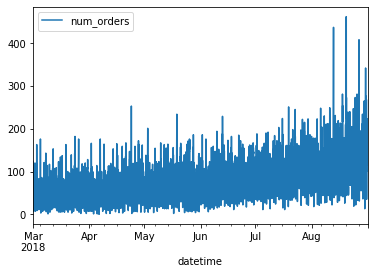

In [4]:
df = df.resample('1H').sum() 
df.plot()

### Вывод:

Исходный датасет состоит из следующих столбцов: 
• datetime — дата и время заказа такси 
• num_orders — количество заказов такси (целевой признак) 
Количество строк в датасете 4416. Пропуски в данных отсутствуют.

Мы сделали предобработку данных и посмотрели на наши данные с количеством вызово за каждый час. Данные имеют большую частоту.

# Анализ
<a class="anchor" id="chapter2"></a>

Найдем сначала лимиты и к

In [5]:
print('Starting date:',df.index.min())
print('Ending date:',df.index.max())
print('Total time:',df.index.max() - df.index.min())
print()
df.describe()

Starting date: 2018-03-01 00:00:00
Ending date: 2018-08-31 23:00:00
Total time: 183 days 23:00:00



,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные собраны за 183 дня и 23 часа. Минимальное количество заказов за 1 час: 0, а максимальное: 462.

Посмотрим на график вызовов по дням:

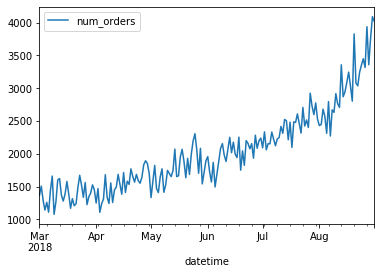

In [6]:
df.resample('1D').sum().plot() 

Посмотрим на скользящую среднюю 100-ю:

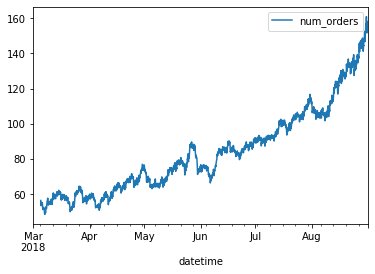

In [7]:
df.rolling(100).mean().plot()

Данные имеют большие колебания, но с помощью средней скользящей мы уже видим восхдящий тренд сползающий вверх.

Теперь проведем анализ временных рядов.

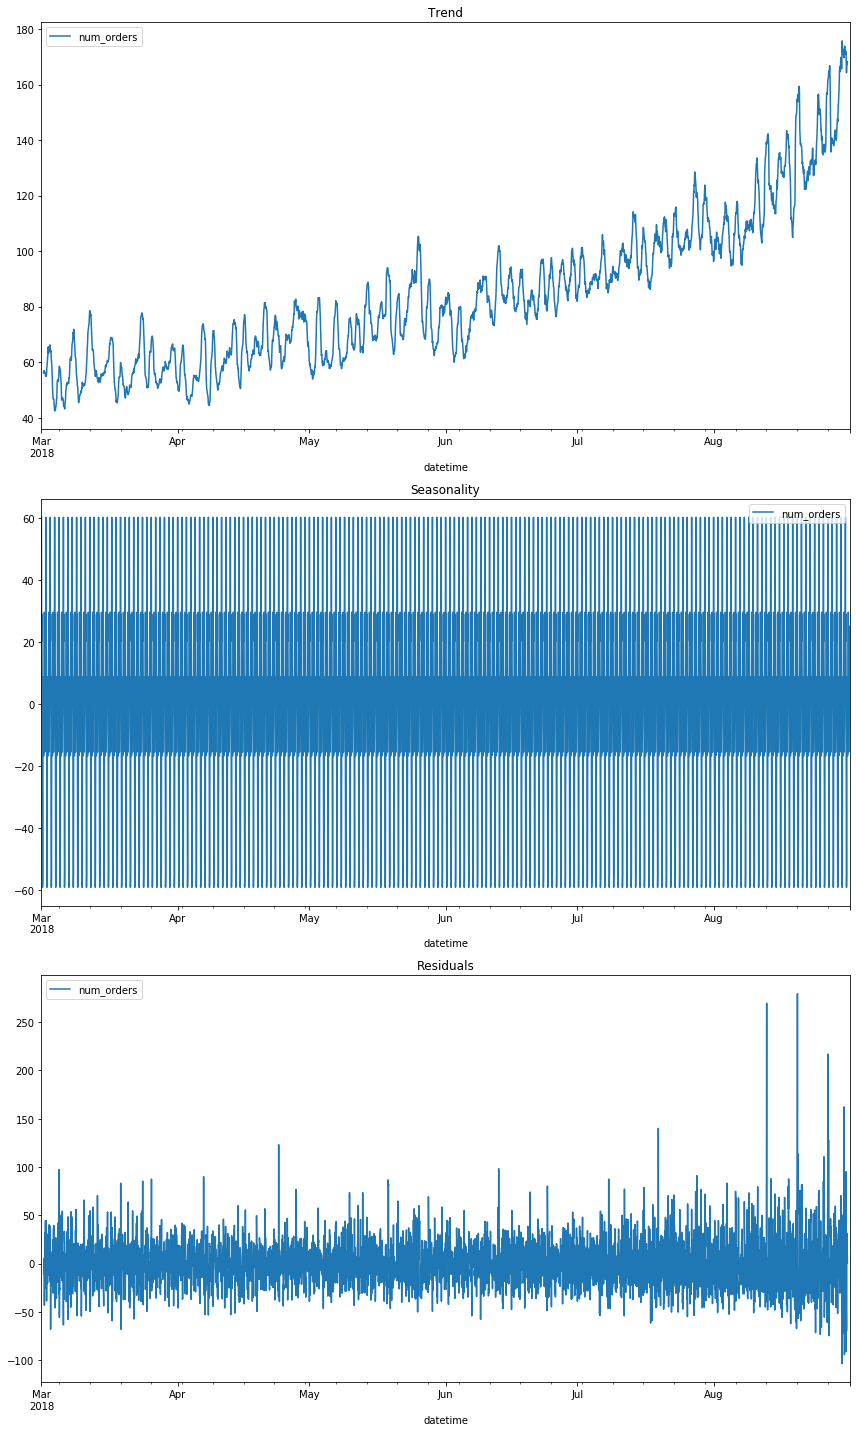

In [8]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Графики показывают высокую частотность и суточную сезонность, уменьшим интервал и посмотрим за неделю:

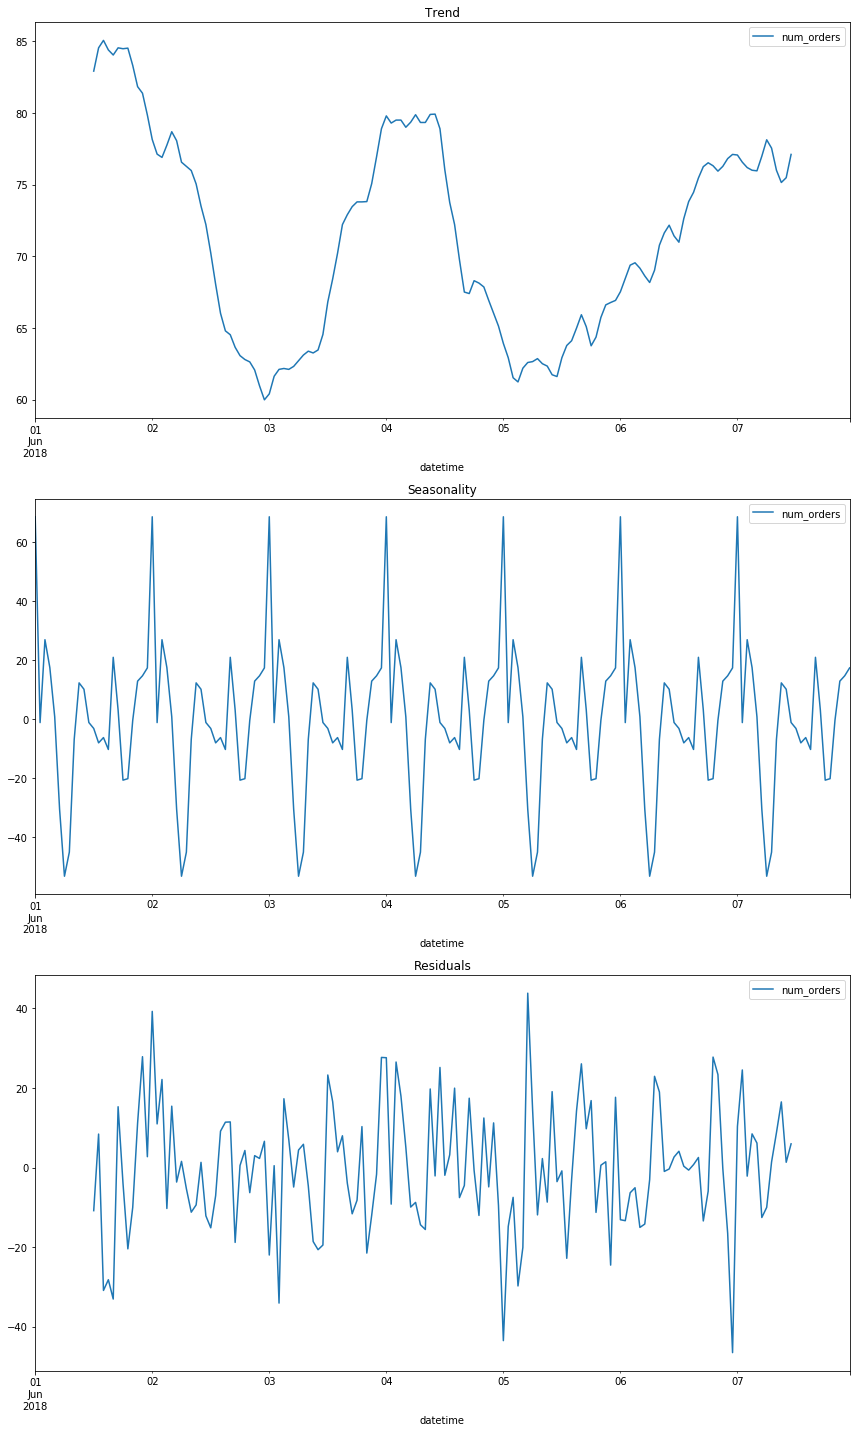

In [9]:
decomposed = seasonal_decompose(df['2018-06-01':'2018-06-07'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Теперь явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

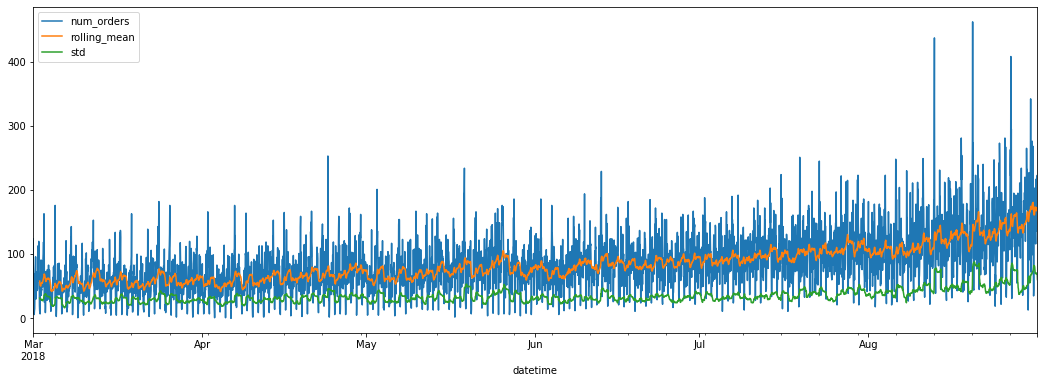

In [10]:
df_plot = df.copy()
df_plot['rolling_mean'] = df_plot.rolling(30).mean()
df_plot['std'] = df_plot['num_orders'].rolling(30).std()
df_plot.plot(figsize=(18, 6))

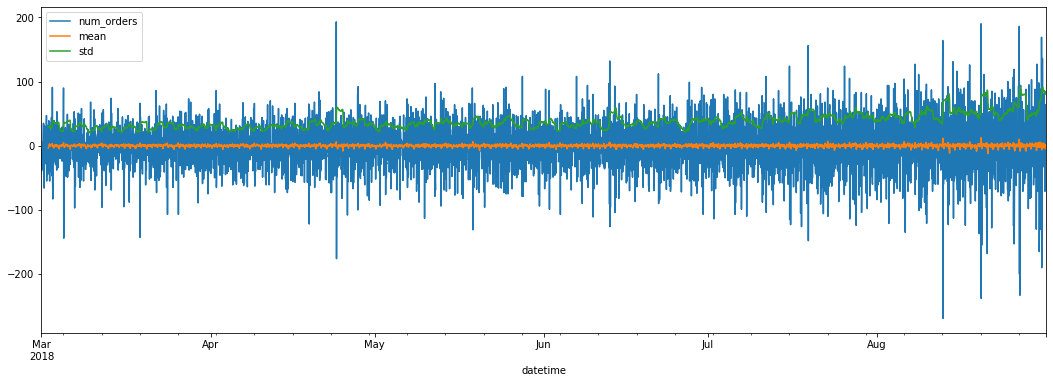

In [11]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(30).mean()
df_shift['std'] = df_shift['num_orders'].rolling(30).std()
df_shift.plot(figsize=(18, 6))

### Вывод:
На этом этапе проведен анализ данных. Методом декомпозиции были выделены следующие аспекты:
1. За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.
2. На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

# Обучение
<a class="anchor" id="chapter3"></a>

Обучим три модели ориентируясь на метрику RMSE. В качестве моделей используем Линейную регрессию, Случайный лес и CatBoostRegressor.

Пропишем функцию для создания признаков, а именно день недели, час -"отстающие значения", скользящее среднее:

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

Применим функцию с лагом до 24 часов и 100-м скользящим средним:

In [13]:
make_features(df, 24, 100)

Удалим пропски и посмотрим данные:

In [14]:
df = df.dropna()

In [15]:
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


Поделим данные на фичи и таргеты:

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 27)
(432, 27)
(3884,)
(432,)


Пропишу функцию для расчета метрики RMSE:

In [18]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

##### Модель линейной регрессии:

В связи с тем, что мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().

In [19]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
#Обучаю модель
regression.fit(features_train, target_train)
#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 28.41240243714249
CPU times: user 318 ms, sys: 327 ms, total: 645 ms
Wall time: 592 ms


##### Модель ансамблей - лес решений:

In [20]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
forest = RandomForestRegressor()
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

CPU times: user 5min 7s, sys: 485 ms, total: 5min 8s
Wall time: 5min 9s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fb556455850>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimator...', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_j

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

In [21]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)
print(forest_params)
print(forest_score)
print('_______________')

{'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 25}
12.995374482742607
_______________
CPU times: user 19.8 ms, sys: 20 µs, total: 19.9 ms
Wall time: 18 ms


##### Модель градиентного бустинга - CatBoost:

In [22]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
cb = cb.CatBoostRegressor()
#Определяю словарь с набором параметров
cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

#Применяю GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8347707	total: 48.4ms	remaining: 48.4s
100:	learn: 17.9492898	total: 699ms	remaining: 6.22s
200:	learn: 16.0842229	total: 1.29s	remaining: 5.13s
300:	learn: 14.8521484	total: 1.89s	remaining: 4.39s
400:	learn: 13.5729537	total: 2.56s	remaining: 3.82s
500:	learn: 12.5203313	total: 3.15s	remaining: 3.13s
600:	learn: 11.7036985	total: 3.9s	remaining: 2.59s
700:	learn: 10.9473044	total: 4.5s	remaining: 1.92s
800:	learn: 10.2835917	total: 5.1s	remaining: 1.27s
900:	learn: 9.6930777	total: 5.85s	remaining: 643ms
999:	learn: 9.0818401	total: 6.52s	remaining: 0us
0:	learn: 31.8722326	total: 2.84ms	remaining: 2.84s
100:	learn: 20.2493589	total: 1.21s	remaining: 10.8s
200:	learn: 18.5101107	total: 2.64s	remaining: 10.5s
300:	learn: 17.4485035	total: 3.91s	remaining: 9.09s
400:	learn: 16.5733982	total: 5.18s	remaining: 7.74s
500:	learn: 15.8244209	total: 6.45s	remaining: 6.42s
600:	learn: 15.1863347	total: 7.71s	remaining: 5.12s
700:	learn: 14.6399190	total: 9.07s	remaining: 3.87s
80

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fb551d2f850>,
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb5561212d0>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

In [23]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)
print(cb_params)
print(cb_score)
print('_______________')

{'depth': 4, 'learning_rate': 0.03}
17.36894752337906
_______________
CPU times: user 15.8 ms, sys: 4.86 ms, total: 20.7 ms
Wall time: 6.74 ms


##### Вывод :
Мы обучили 3 модели и подобрали гиперпараметры методом грид серч.

#  Тестирование
<a class="anchor" id="chapter4"></a>

##### Тест на адекватность модели:

In [24]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))

RMSE для проверки модели на адекватность: 59.157


##### Модель линейной регрессии:

In [25]:
%%time
#Обучаю модель
regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

#Определяю метрику RMSE
regression_RMSE = round(RMSE(target_test, regression_model_predictions), 3)
print('RMSE модели Линейной регрессии:', regression_RMSE)

RMSE модели Линейной регрессии: 45.174
CPU times: user 22.6 ms, sys: 13.5 ms, total: 36.2 ms
Wall time: 8.79 ms


Пропишем функцию для построения сравнительных графиков "целевой признак - предсказание модели":

In [26]:
def graphicaizer(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6))
    model_data['2018-08-22':'2018-08-24'].plot(figsize=(18, 6))

Сравниваю наши данные и что мы предсказали по графику:

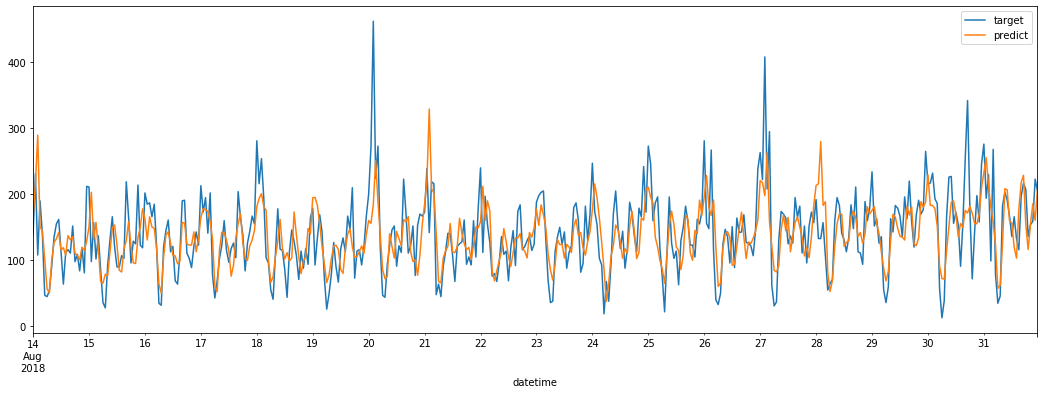

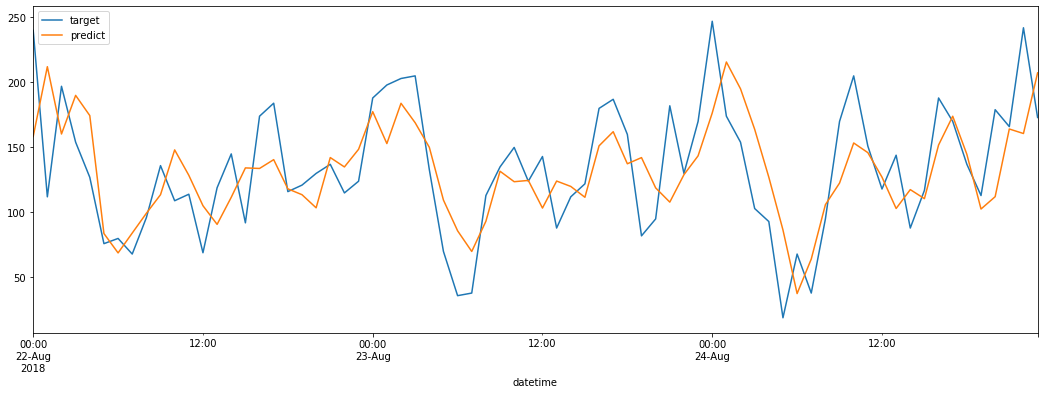

In [27]:
graphicaizer(regression_model_predictions)

##### Модель ансамблей - лес решений:

In [28]:
%%time
#Обучаю модель на оптимальных гиперпараметрах
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

#Определяю метрику RMSE
forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 42.798
CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.3 s


Объявляю функцию для построения графика важности признаков, она будет показывать только те признаки,важность которых больше 0.0:

In [29]:
def feature_importance_hist(model, features_train):
    importances = list(model.feature_importances_)
    names_indices = features_train.columns
    not_null_importances = []
    not_null_indices = []

    for i in importances:
        if i>0:
            not_null_importances.append(i)
            not_null_indices.append(names_indices[importances.index(i)])
    
    plt.figure(figsize=(15, 10))
    plt.title("Feature importances")
 
    plt.bar(range(len(not_null_importances)), not_null_importances, color="g")
    plt.xticks(range(len(importances)), not_null_indices, rotation=90)
 
    plt.tight_layout()
    plt.xlim([-1, len(not_null_importances)])
    plt.show()

Сравниваю наши данные и что мы предсказали по графику:

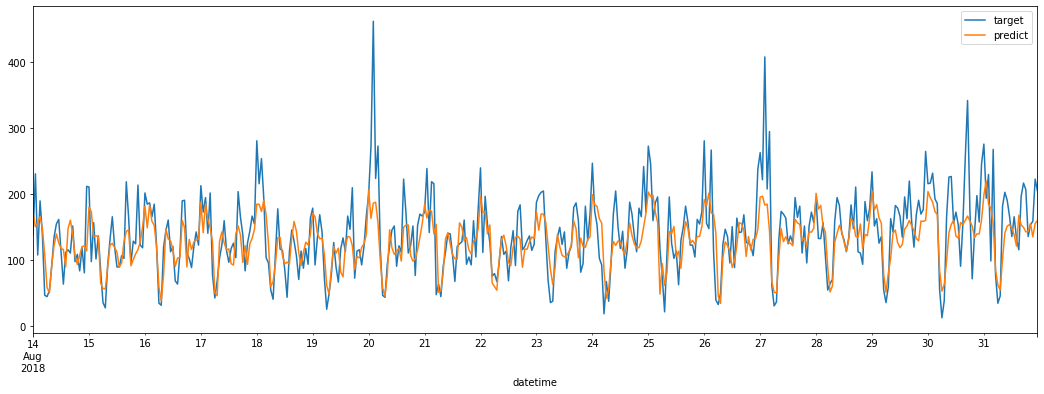

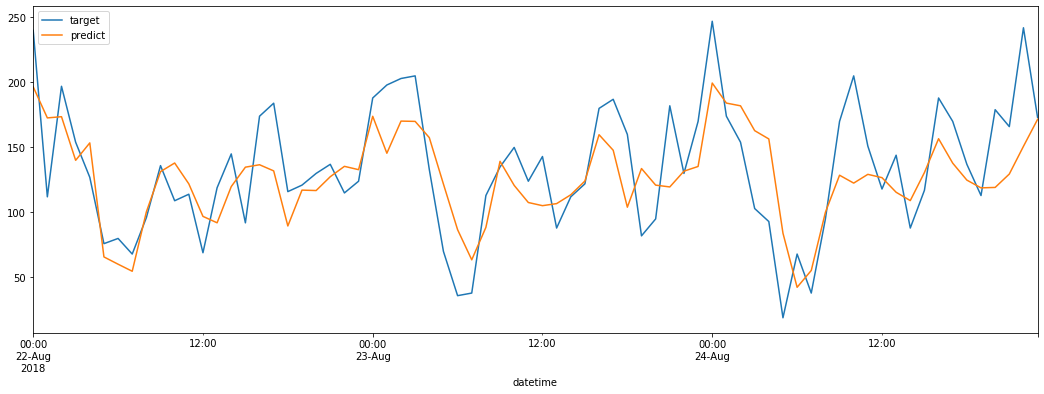

In [30]:
graphicaizer(forest_model_predictions)

Строю график важности признаков модели:

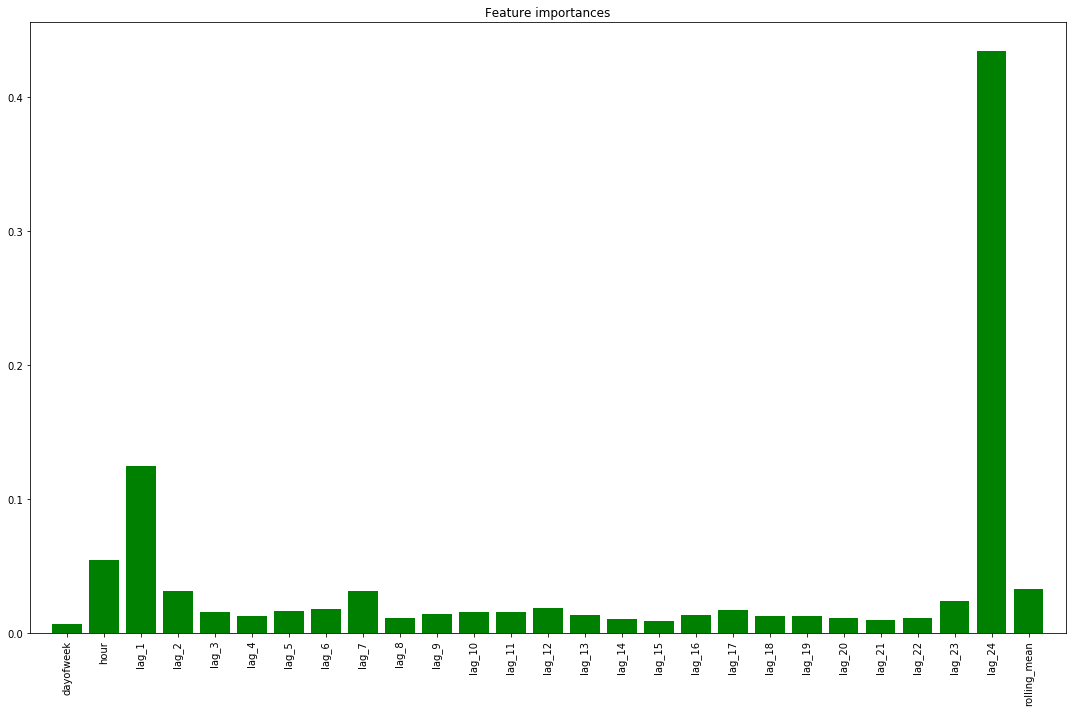

In [31]:
feature_importance_hist(forest_model, features_train)

##### Модель градиентного бустинга - CatBoost:

In [35]:
%%time

#Обучаю модель на оптимальных гиперпараметрах
cb_model = cb.CatBoostRegressor(learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=100)
cb_model_predictions = cb_model.predict(features_test)

#Определяю метрику RMSE
cb_RMSE = round(RMSE(target_test, cb_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

0:	learn: 38.2170015	total: 2.1ms	remaining: 2.1s
100:	learn: 24.2669641	total: 1.66s	remaining: 14.7s
200:	learn: 22.8477524	total: 3.31s	remaining: 13.2s
300:	learn: 21.6907833	total: 4.98s	remaining: 11.6s
400:	learn: 20.7671769	total: 6.64s	remaining: 9.92s
500:	learn: 19.9969797	total: 8.3s	remaining: 8.27s
600:	learn: 19.3650453	total: 9.88s	remaining: 6.56s
700:	learn: 18.7896640	total: 11.6s	remaining: 4.96s
800:	learn: 18.2751178	total: 13.3s	remaining: 3.3s
900:	learn: 17.7967185	total: 15s	remaining: 1.64s
999:	learn: 17.3689475	total: 16.6s	remaining: 0us
RMSE модели CatBoostRegressor: 40.889
CPU times: user 14.6 s, sys: 2.41 s, total: 17 s
Wall time: 20.7 s


Сравниваю наши данные и что мы предсказали по графику:

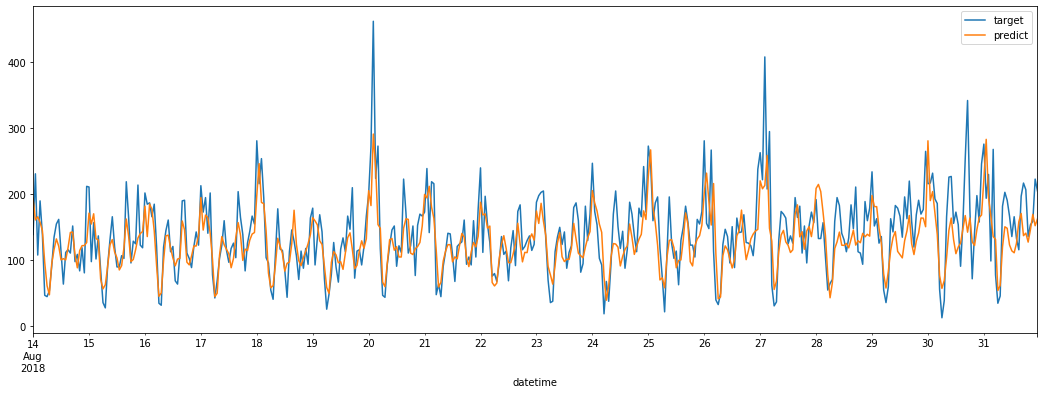

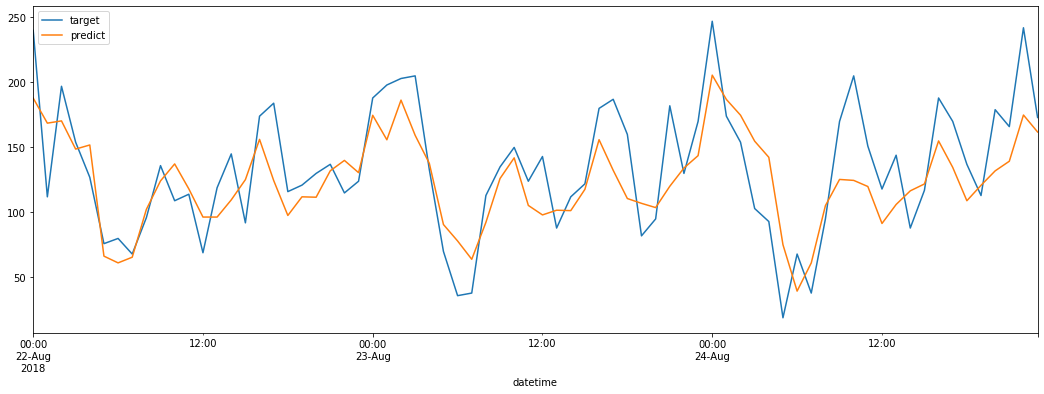

In [36]:
graphicaizer(cb_model_predictions)

Строю график важности признаков модели:

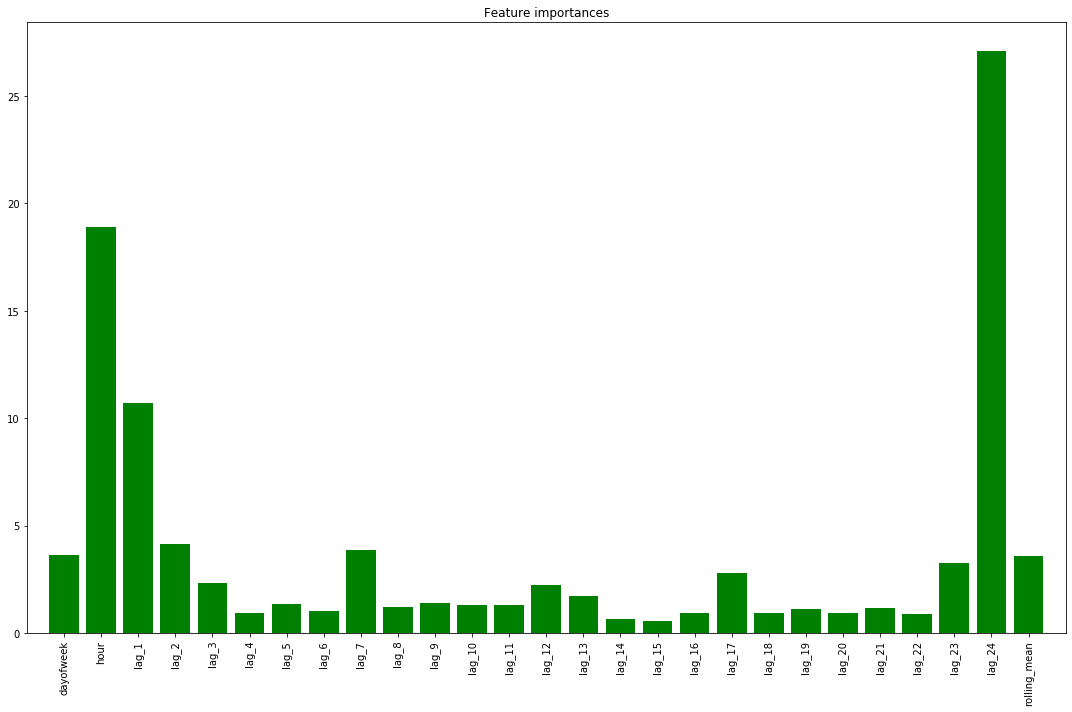

In [37]:
feature_importance_hist(cb_model, features_train)

Cмотрим итоговые RMSE для каждой модели, наилучшей будет та ммодель у которой отклонение минимально:

In [38]:
print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))
print('RMSE модели Линейной регрессии:', regression_RMSE)
print('RMSE модели Случайного леса:', forest_RMSE)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

RMSE для проверки модели на адекватность: 59.157
RMSE модели Линейной регрессии: 45.174
RMSE модели Случайного леса: 42.798
RMSE модели CatBoostRegressor: 40.889


Поздравляю, в лидерах у нас модель CatBoostRegressor с RMSE = 40,889.

#  Общий вывод:
<a class="anchor" id="chapter5"></a>

При выполнении проекта проделана следующая работа:
- На первом этапе произведена загрузка данных и их подготовка для обучения моделей.:
- За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.
- На третьем этапе к датасету были добавлены дополнительные признаки, а именно день недели, час "отстающие значения" и скользящее среднее. На дополнном датасете подобраны оптимальные гиперпараметры для моделей.
- На четвертом этапе проведено тестирование всех моделей, каждой из них удалось достичь требуемого показателя метрики RMSE. Анализ сравнительных графиков в двух масштабах, показал, что модели хуже всего справляются с предсказаниями на высоких пиках и на провалах, но в целом, угадывают направления движения. Наилучший показатель RMSE в данном случае у CatBoostRegressor = 40,889.

Дополнительно можно отметить, что хорошо было бы провести анализ вызовов такси в отдаленные места - аэропорты, торговые центры на окраине, ближайший пригород.

# Чек-лист проверки
<a class="anchor" id="chapter5"></a>

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48